Step 1: Mesh creation

In [1]:
from MatlabFuncs import *
from model import *
#from EnumDefinitions import *
from numpy import *
from triangle import *
from setmask import *
from parameterize import *
from setflowequation import *
from solve import *
from math import *
#from paterson import *
from SetIceShelfBC import *
from generic import *
#from EnumToString import *
from pairoptions import *
from scipy import *
#from plotmodel import *
import matplotlib.pyplot as plt
#from matplotlib import colors
from matplotlib import rc
from matplotlib.ticker import LogFormatter
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import LogNorm
from squaremesh import *
from roundmesh import *
from triangle import *
import InterpFromGridToMesh


from generic import generic
import netCDF4 as nc

Step 1: Mesh creation

In [2]:
# Generate initial uniform mesh (resolution = 20000 m)

md=model()

md=triangle(md,'DomainOutline.exp',20000)


In [3]:
# Get velocities
ncdata = 'Greenland_5km_dev1.2.nc'
file = nc.Dataset(ncdata,'r')
x1 = file.variables['x1'][:]
y1 = file.variables['y1'][:]
velx = file.variables['surfvelx'][:]
vely = file.variables['surfvely'][:]
file.close()

In [4]:
# Change data type from double pyarray to int64
x1=x1.astype('int64')
y1=y1.astype('int64')
velx=velx.astype('int64')
vely=vely.astype('int64')

In [5]:
# Convert matrix data into the correct dimensions
velx=velx.transpose()
vely=vely.transpose()
velx=velx.reshape(301,561)
vely=vely.reshape(301,561)

In [6]:
vx   = InterpFromGridToMesh.InterpFromGridToMesh(x1,y1,velx.transpose(),md.mesh.x,md.mesh.y,0)
vy   = InterpFromGridToMesh.InterpFromGridToMesh(x1,y1,vely.transpose(),md.mesh.x,md.mesh.y,0)

In [7]:
vel  = sqrt(multiply(vx,vx)+multiply(vy,vy))

/tmp/ipykernel_2498/128909970.py:1: DeprecationWarning: scipy.multiply is deprecated and will be removed in SciPy 2.0.0, use numpy.multiply instead
  vel  = sqrt(multiply(vx,vx)+multiply(vy,vy))
/tmp/ipykernel_2498/128909970.py:1: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  vel  = sqrt(multiply(vx,vx)+multiply(vy,vy))


In [8]:
# Mesh Greenland
import bamg
md = bamg.bamg(md,'hmax',400000,'hmin',5000,'gradation',1.7,'field',vel.transpose(),'err',8)
#md = bamg.bamg(md,'hmax',400000,'hmin',5000,'gradation',1.7,'field',vel,'err',8)
#vel

Anisotropic mesh adaptation

   new number of triangles = 5420


In [9]:
# Convert x,y coordinates (Polar stereo) to lat/lon
import xy2ll
[md.mesh.lat,md.mesh.long]=xy2ll.xy2ll(md.mesh.x,md.mesh.y,+1,39,71)

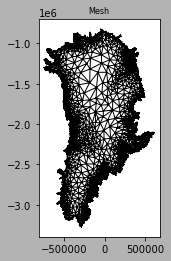

In [10]:
plotmodel (md,'data','mesh')

In [11]:
#### How to save and load the model in python????????
#import save

#save.save Greenland_Mesh_Generation md

Step 2: Parameterization

In [12]:
#from setmask import *
#md = setmask.setmask(md,'','')  #all ice is grounded
#md=setmask(md,'all','')
md=setmask(md,'','')

In [13]:
#import parameterize
# md = parameterize(md,'Greenland.par')

from parameterize import *
#md = parameterize(md,'/home/jovyan/issm-smce-starter-pack/Greenland/Greenland.par')
md=parameterize(md,'./Greenland.py')

   Loading SeaRISE data from NetCDF
   Interpolating surface and bedrock
   Constructing thickness
   Interpolating velocities 
   Interpolating temperatures
   Interpolating surface mass balance
   Construct basal friction parameters
   Construct ice rheological properties
   Set other boundary conditions
   Set geothermal heat flux
   Set Pressure
   Single point constraints


In [14]:
from setflowequation import *
md = setflowequation(md,'SSA','all')

Step 3: Control method friction

In [15]:
#    Control general
md.inversion.iscontrol=1  # Do inversion? 1 = yes; 0 = no
md.inversion.nsteps=30 # number of inversion steps
md.inversion.step_threshold=multiply(0.99,ones((md.inversion.nsteps,1)))  # Original value was 0.5
md.inversion.maxiter_per_step=multiply(5,ones((md.inversion.nsteps,1)))   # Original value was 5

/tmp/ipykernel_2498/4175135628.py:4: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  md.inversion.step_threshold=multiply(0.99,ones((md.inversion.nsteps,1)))  # Original value was 0.5
/tmp/ipykernel_2498/4175135628.py:4: DeprecationWarning: scipy.multiply is deprecated and will be removed in SciPy 2.0.0, use numpy.multiply instead
  md.inversion.step_threshold=multiply(0.99,ones((md.inversion.nsteps,1)))  # Original value was 0.5
/tmp/ipykernel_2498/4175135628.py:5: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  md.inversion.maxiter_per_step=multiply(5,ones((md.inversion.nsteps,1)))   # Original value was 5
/tmp/ipykernel_2498/4175135628.py:5: DeprecationWarning: scipy.multiply is deprecated and will be removed in SciPy 2.0.0, use numpy.multiply instead
  md.inversion.maxiter_per_step=multiply(5,ones((md.inversion.nsteps,1)))   # Original value was 5


In [16]:
# Cost functions
md.inversion.cost_functions=array([101, 103, 501])     # This is the same as VarGlaS
md.inversion.cost_functions_coefficients=ones((md.mesh.numberofvertices,3))
md.inversion.cost_functions_coefficients[:,0]=350
md.inversion.cost_functions_coefficients[:,1]=0.6
md.inversion.cost_functions_coefficients[:,2]=0.000002

/tmp/ipykernel_2498/4195464215.py:2: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  md.inversion.cost_functions=array([101, 103, 501])     # This is the same as VarGlaS
/tmp/ipykernel_2498/4195464215.py:3: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  md.inversion.cost_functions_coefficients=ones((md.mesh.numberofvertices,3))


In [25]:
# Controls
md.inversion.control_parameters=['FrictionCoefficient']
md.inversion.gradient_scaling=multiply(50,ones((md.inversion.nsteps,1)))
md.inversion.min_parameters=multiply(1,ones((md.mesh.numberofvertices,1)))
md.inversion.max_parameters=multiply(200,ones((md.mesh.numberofvertices,1)))

/tmp/ipykernel_2498/2607277758.py:3: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  md.inversion.gradient_scaling=multiply(50,ones((md.inversion.nsteps,1)))
/tmp/ipykernel_2498/2607277758.py:3: DeprecationWarning: scipy.multiply is deprecated and will be removed in SciPy 2.0.0, use numpy.multiply instead
  md.inversion.gradient_scaling=multiply(50,ones((md.inversion.nsteps,1)))
/tmp/ipykernel_2498/2607277758.py:4: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  md.inversion.min_parameters=multiply(1,ones((md.mesh.numberofvertices,1)))
/tmp/ipykernel_2498/2607277758.py:4: DeprecationWarning: scipy.multiply is deprecated and will be removed in SciPy 2.0.0, use numpy.multiply instead
  md.inversion.min_parameters=multiply(1,ones((md.mesh.numberofvertices,1)))
/tmp/ipykernel_2498/2607277758.py:5: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0

In [28]:
#  Additional parameters
md.stressbalance.restol=0.01
md.stressbalance.reltol=0.1
md.stressbalance.abstol=NaN
md.stressbalance.loadingforce = np.zeros((md.mesh.numberofvertices, 3))

In [29]:
# Solve for StressbalanceSolution
from generic import *
from solve import *

md.cluster=generic('name',oshostname(),'np',1,'login','username')
md.toolkits=toolkits()
md.verbose=verbose('solution',True,'control',True)
#md=solve(md,StressbalanceSolutionEnum())
#md=solve(md,'Stressbalance')
md=solve(md,'sb')
#savevars('./Models/Greenland.StressbalanceSolution','md',md)

checking model consistency
marshalling file SeaRISEgreenland.bin
uploading input file and queueing script
launching solution sequence on remote cluster

Ice-sheet and Sea-level System Model (ISSM) version  4.21
(website: http://issm.jpl.nasa.gov contact: issm@jpl.nasa.gov)

call computational core:
   preparing initial solution

       x       |  Cost function f(x)  |  List of contributions
====================== step 1/30 ===============================
 x =         0 |    computing velocities
   computing adjoint
   saving results
f(x) =     158721.3  |       7213.984     151507.3 5.487051e-32
 x =         1 | f(x) =     141852.9  |        4744.16     137108.7   0.03249748
====================== step 2/30 ===============================
 x =         0 |    computing velocities
   computing adjoint
   saving results
f(x) =     141850.4  |       4743.437     137106.9   0.03249748
 x =         1 | f(x) =     127871.4  |       3148.944     124722.3    0.1742769
====================== ste